# Customer Revenue Prediction

## 1. Look at the big picture

### The Task

The 80/20 rule has proven true for many businesses; only a small percentage of customers produce most of the revenue. As such, marketing teams are challenged to make appropriate investments in promotional strategies.

RStudio, the developer of free and open tools for R and enterprise-ready products for teams to scale and share work, has partnered with Google Cloud and Kaggle to demonstrate the business impact that thorough data analysis can have.

The goal of this task is to analyze a Google Merchandise Store (GStore) customer dataset to predict revenue per customer. Hopefully, the outcome will be more actionable operational changes and a better use of marketing budgets for those companies who choose to use data analysis on top of GA data. 

### The Plan

We are predicting the natural log of the sum of all transactions per user. Once the data is updated this will be for all users in the test set for December 1st, 2018 to January 31st, 2019. For every user in the test set, the target is:
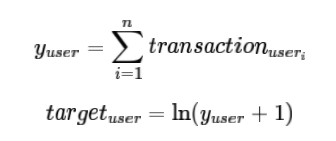

We will follow the eight main steps for ML projects, given by the book "Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow": 
1. Look at the big picture
2. Get the data
3. Discover and visualize the data to gain insights 
4. Prepare the data for Machine Learning algorithms
5. Select a model and train it
6. Fine-tune your model
7. Present your solution
8. Launch, monitor and maintain your system

We will be using RMSE for performance measure. 

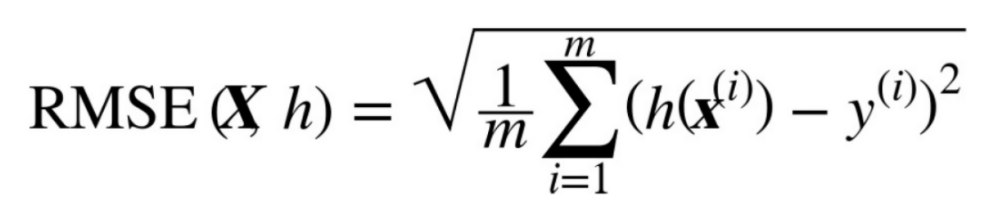

## 2. Get the data

The dataset consists of two parts:

* train_v2.csv - the updated training set - contains user transactions from August 1st 2016 to April 30th 2018.
* test_v2.csv - the updated test set - contains user transactions from May 1st 2018 to October 15th 2018.

In [3]:
#Setup

%matplotlib inline
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import time
import json
from pandas import json_normalize

Loading the dataframe with json fields. 

In [4]:
def load_df(csv_path, nrows = None):
    json_cols = ['device', 'geoNetwork', 'totals', 'trafficSource']
    df = pd.read_csv(csv_path,
                     #converters are dict of functions for converting values in certain columns. Keys can either be integers or column labels.
                     #json.loads() method can be used to parse a valid JSON string and convert it into a Python Dictionary.
                     #It is mainly used for deserializing native string, byte, or byte array which consists of JSON data into Python Dictionary.
                     converters = {col: json.loads for col in json_cols},                                                                         
                         dtype = {'fullVisitorId': 'str'}, # Important!!
                         nrows = nrows)
    for col in json_cols:
        # for each column, flatten data frame such that the values of a single col are spread in different cols
        # This will use subcol as names of flat_col.columns
        flat_col = json_normalize(df[col])
        # Name the columns in this flatten data frame as col.subcol for tracability
        flat_col.columns = [f"{col}.{subcol}" for subcol in flat_col.columns]
        # Drop the json_col and instead add the new flat_col
        df = df.drop(col, axis = 1).merge(flat_col, right_index = True, left_index = True)
    return df
import os
print(os.listdir("../dat158ml-customer-revenue"))

['.ipynb_checkpoints', 'app.ipynb', 'app.py', 'ML_group24.ipynb', 'model.pkl', 'model1.pkl', 'sample_submission_v2.csv', 'StreamlitApp.py', 'test_v2.csv', 'train_v2.csv']


In [5]:
csv_train_path = '../dat158ml-customer-revenue/train_v2.csv'
csv_test_path = '../dat158ml-customer-revenue/test_v2.csv'

In [6]:
%%time
train = load_df(csv_train_path, nrows = 120000)
test = load_df(csv_test_path, nrows = None)
train.shape, test.shape

Wall time: 3min 30s


((120000, 60), (401589, 59))

### A quick look at the Data Structure 

We are able to look at the top five rows using the DataFrame's head() method.

In [5]:
train.head()

,channelGrouping,customDimensions,date,fullVisitorId,hits,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,...,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.referralPath,trafficSource.isTrueDirect,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.campaignCode
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,3162355547410993243,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,1508198450,1,1508198450,Firefox,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,8934116514970143966,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,1508176307,6,1508176307,Chrome,...,not available in demo dataset,/a/google.com/transportation/mtv-services/bike...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Direct,"[{'index': '4', 'value': 'North America'}]",20171016,7992466427990357681,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,1508201613,1,1508201613,Chrome,...,not available in demo dataset,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,9075655783635761930,"[{'hitNumber': '1', 'time': '0', 'hour': '9', ...",Not Socially Engaged,1508169851,1,1508169851,Chrome,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Organic Search,"[{'index': '4', 'value': 'Central America'}]",20171016,6960673291025684308,"[{'hitNumber': '1', 'time': '0', 'hour': '14',...",Not Socially Engaged,1508190552,1,1508190552,Chrome,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
test.head()

,channelGrouping,customDimensions,date,fullVisitorId,hits,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,...,trafficSource.medium,trafficSource.keyword,trafficSource.adContent,trafficSource.isTrueDirect,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd
0,Organic Search,"[{'index': '4', 'value': 'APAC'}]",20180511,7460955084541987166,"[{'hitNumber': '1', 'time': '0', 'hour': '21',...",Not Socially Engaged,1526099341,2,1526099341,Chrome,...,organic,(not provided),(not set),True,not available in demo dataset,NaN,NaN,NaN,NaN,NaN
1,Direct,"[{'index': '4', 'value': 'North America'}]",20180511,460252456180441002,"[{'hitNumber': '1', 'time': '0', 'hour': '11',...",Not Socially Engaged,1526064483,166,1526064483,Chrome,...,(none),(not set),(not set),True,not available in demo dataset,NaN,NaN,NaN,NaN,NaN
2,Organic Search,"[{'index': '4', 'value': 'North America'}]",20180511,3461808543879602873,"[{'hitNumber': '1', 'time': '0', 'hour': '12',...",Not Socially Engaged,1526067157,2,1526067157,Chrome,...,organic,(not provided),(not set),True,not available in demo dataset,NaN,NaN,NaN,NaN,NaN
3,Direct,"[{'index': '4', 'value': 'North America'}]",20180511,975129477712150630,"[{'hitNumber': '1', 'time': '0', 'hour': '23',...",Not Socially Engaged,1526107551,4,1526107551,Chrome,...,(none),(not set),(not set),True,not available in demo dataset,NaN,NaN,NaN,NaN,NaN
4,Organic Search,"[{'index': '4', 'value': 'North America'}]",20180511,8381672768065729990,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,1526060254,1,1526060254,Internet Explorer,...,organic,(not provided),(not set),NaN,not available in demo dataset,NaN,NaN,NaN,NaN,NaN


We use the info() method to get info about total number of rows, each attribute's type and the number of nonnull values.

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 60 columns):
 #   Column                                             Non-Null Count   Dtype 
---  ------                                             --------------   ----- 
 0   channelGrouping                                    120000 non-null  object
 1   customDimensions                                   120000 non-null  object
 2   date                                               120000 non-null  int64 
 3   fullVisitorId                                      120000 non-null  object
 4   hits                                               120000 non-null  object
 5   socialEngagementType                               120000 non-null  object
 6   visitId                                            120000 non-null  int64 
 7   visitNumber                                        120000 non-null  int64 
 8   visitStartTime                                     120000 non-null  int64 
 9   devi

In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401589 entries, 0 to 401588
Data columns (total 59 columns):
 #   Column                                             Non-Null Count   Dtype 
---  ------                                             --------------   ----- 
 0   channelGrouping                                    401589 non-null  object
 1   customDimensions                                   401589 non-null  object
 2   date                                               401589 non-null  int64 
 3   fullVisitorId                                      401589 non-null  object
 4   hits                                               401589 non-null  object
 5   socialEngagementType                               401589 non-null  object
 6   visitId                                            401589 non-null  int64 
 7   visitNumber                                        401589 non-null  int64 
 8   visitStartTime                                     401589 non-null  int64 
 9   devi

## 3. Dicover and Visualize the Data to Gain Insights 

Make copies on train- and test-set.

In [9]:
copyTrain = train.copy()

In [10]:
copyTest = test.copy()

In [11]:
#Target
y_train_ = copyTrain['totals.transactionRevenue']
y_train_.fillna(0, inplace = True)
y_train_.astype('float')

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
119995    0.0
119996    0.0
119997    0.0
119998    0.0
119999    0.0
Name: totals.transactionRevenue, Length: 120000, dtype: float64

We start by visualising the total transaction revenue in relations to the geography. We see the distribution between the continents. America is the continent with the clearly largest transaction revenue. 

<AxesSubplot:xlabel='totals.transactionRevenue', ylabel='geoNetwork.continent'>

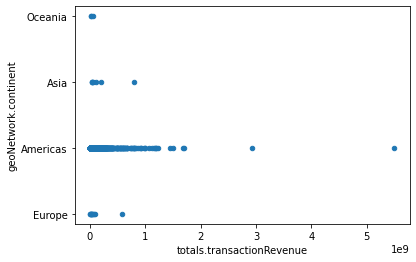

In [8]:
train.plot(kind="scatter", x="totals.transactionRevenue", y="geoNetwork.continent")

Looking at which campaigns brought the most transaction revenue. 

<AxesSubplot:xlabel='totals.totalTransactionRevenue', ylabel='trafficSource.campaign'>

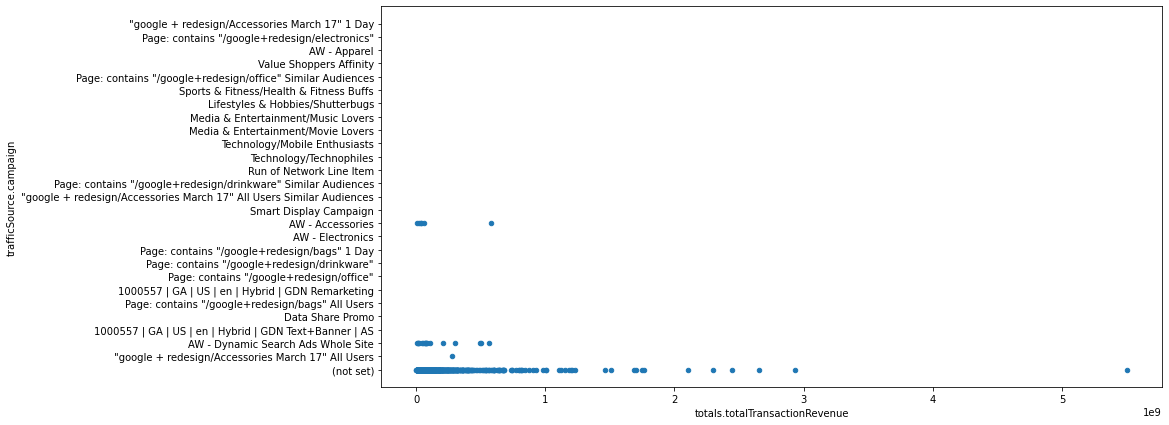

In [13]:
copyTrain.plot(kind="scatter", x="totals.totalTransactionRevenue", y="trafficSource.campaign", figsize=(14, 7))

We take a look at which browser gets the most transaction revenue. Chrome has the most. 

<AxesSubplot:xlabel='totals.totalTransactionRevenue', ylabel='device.browser'>

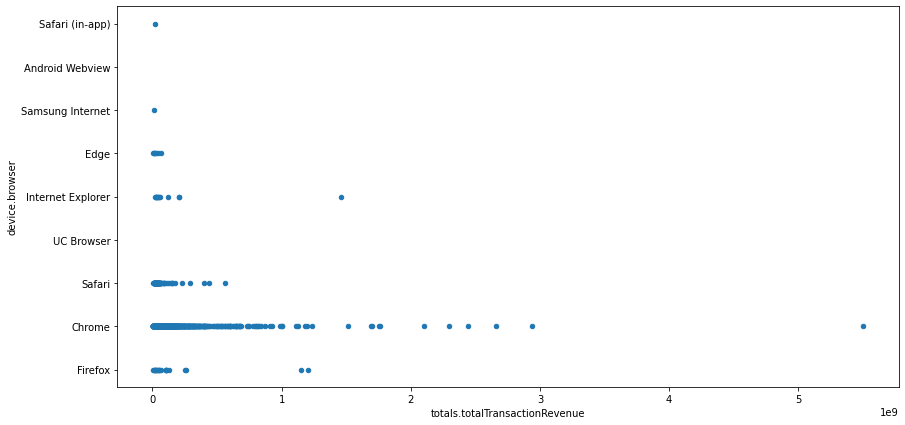

In [13]:
train.plot(kind="scatter", x="totals.totalTransactionRevenue", y="device.browser", figsize=(14, 7))

## 4. Prepare the Data for Machine Learning Algorithms 

### Data cleaning

Checking which columns has missing values.

In [14]:
cols=copyTrain.columns
missing_val = pd.DataFrame()
for col in cols:
    na_count = copyTrain[col].isna().sum()
    if na_count != 0:
        missing_val.loc[col, 'NaN_val(%)'] = na_count/len(copyTrain)*100
print('Number of columns with missing values in train set:', len(missing_val))
missing_val.sort_values('NaN_val(%)', inplace = True)
missing_val

Number of columns with missing values in train set: 17


,NaN_val(%)
totals.pageviews,0.010000
totals.newVisits,23.768333
totals.bounces,49.532500
totals.timeOnSite,50.611667
totals.sessionQualityDim,54.761667
trafficSource.keyword,66.640000
trafficSource.referralPath,67.336667
trafficSource.isTrueDirect,69.450833
trafficSource.adwordsClickInfo.gclId,94.719167
trafficSource.adwordsClickInfo.isVideoAd,94.763333


Dropping the columns that have more than 48% missing values. The other columns that have missing values are set to 0.

In [15]:
for col in missing_val.index:
    if missing_val.loc[col, 'NaN_val(%)'] > 48: 
        copyTrain.drop(col, axis = 1, inplace = True)
    else: 
        copyTrain[col].fillna('0', inplace = True)

In [16]:
#Check if there are attributes in test that are not in train
print(set(copyTest.columns).difference(set(copyTrain.columns)))

{'trafficSource.adContent', 'trafficSource.adwordsClickInfo.page', 'trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.adwordsClickInfo.gclId', 'trafficSource.isTrueDirect', 'trafficSource.keyword', 'trafficSource.adwordsClickInfo.slot', 'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.referralPath', 'totals.bounces', 'totals.transactions', 'totals.sessionQualityDim', 'totals.totalTransactionRevenue', 'totals.timeOnSite'}


In [17]:
#Dropping attributes in test that are not in train. 

cols_to_drop = ['trafficSource.isTrueDirect', 'trafficSource.adwordsClickInfo.page', 'totals.bounces', 'trafficSource.keyword', 'trafficSource.referralPath', 'trafficSource.adwordsClickInfo.slot', 'trafficSource.adwordsClickInfo.gclId', 'totals.sessionQualityDim', 'totals.transactions', 'totals.totalTransactionRevenue', 'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.adContent', 'totals.timeOnSite', 'trafficSource.adwordsClickInfo.adNetworkType']


copyTest = copyTest.drop(cols_to_drop, axis=1)

In [18]:
#Check if there are attributes in train that are not in test
print(set(copyTrain.columns).difference(set(copyTest.columns)))

set()


### Removing constant values.

In [19]:
#Checking for constant values in train
const_cols = [c for c in copyTrain.columns if copyTrain[c].nunique(dropna=False)==1 ]
const_cols

['socialEngagementType',
 'device.browserVersion',
 'device.browserSize',
 'device.operatingSystemVersion',
 'device.mobileDeviceBranding',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.flashVersion',
 'device.language',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'trafficSource.adwordsClickInfo.criteriaParameters']

In [20]:
#Removing attributes with constant values from train
for col in const_cols:
    if col not in missing_val.index:
        copyTrain.drop(col, axis = 1, inplace = True)

print('Number of columns in the training set',len(copyTrain.columns))

Number of columns in the training set 26


In [21]:
#Check again which attributes are in test that are not in train
print(set(copyTest.columns).difference(set(copyTrain.columns)))

{'device.language', 'geoNetwork.latitude', 'socialEngagementType', 'geoNetwork.cityId', 'device.screenResolution', 'geoNetwork.longitude', 'device.mobileDeviceMarketingName', 'device.mobileDeviceModel', 'device.mobileDeviceInfo', 'device.screenColors', 'device.mobileInputSelector', 'device.browserVersion', 'device.operatingSystemVersion', 'device.mobileDeviceBranding', 'device.browserSize', 'totals.visits', 'geoNetwork.networkLocation', 'trafficSource.adwordsClickInfo.criteriaParameters', 'device.flashVersion'}


In [22]:
cols_to_drop2 = ['device.language', 'device.screenResolution', 'totals.visits', 'device.screenColors', 'device.operatingSystemVersion', 'device.mobileDeviceInfo', 'socialEngagementType', 'device.mobileDeviceModel', 'geoNetwork.networkLocation', 'device.browserSize', 'device.browserVersion', 'geoNetwork.latitude', 'device.mobileDeviceBranding', 'geoNetwork.cityId', 'trafficSource.adwordsClickInfo.criteriaParameters', 'geoNetwork.longitude', 'device.flashVersion', 'device.mobileInputSelector', 'device.mobileDeviceMarketingName']


copyTest = copyTest.drop(cols_to_drop2, axis=1)

In [23]:
copyTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 26 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   channelGrouping            120000 non-null  object
 1   customDimensions           120000 non-null  object
 2   date                       120000 non-null  int64 
 3   fullVisitorId              120000 non-null  object
 4   hits                       120000 non-null  object
 5   visitId                    120000 non-null  int64 
 6   visitNumber                120000 non-null  int64 
 7   visitStartTime             120000 non-null  int64 
 8   device.browser             120000 non-null  object
 9   device.operatingSystem     120000 non-null  object
 10  device.isMobile            120000 non-null  bool  
 11  device.deviceCategory      120000 non-null  object
 12  geoNetwork.continent       120000 non-null  object
 13  geoNetwork.subContinent    120000 non-null  

In [24]:
copyTest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401589 entries, 0 to 401588
Data columns (total 26 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   channelGrouping            401589 non-null  object
 1   customDimensions           401589 non-null  object
 2   date                       401589 non-null  int64 
 3   fullVisitorId              401589 non-null  object
 4   hits                       401589 non-null  object
 5   visitId                    401589 non-null  int64 
 6   visitNumber                401589 non-null  int64 
 7   visitStartTime             401589 non-null  int64 
 8   device.browser             401589 non-null  object
 9   device.operatingSystem     401589 non-null  object
 10  device.isMobile            401589 non-null  bool  
 11  device.deviceCategory      401589 non-null  object
 12  geoNetwork.continent       401589 non-null  object
 13  geoNetwork.subContinent    401589 non-null  

Filling in the missing values in the test set with the median. 

In [25]:
median = copyTest["totals.newVisits"].median()
copyTest["totals.newVisits"].fillna(median, inplace=True)

### Converting categorial/text values to numerical values. Using sklearn's LabelEncoder. 

In [26]:
copyTest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401589 entries, 0 to 401588
Data columns (total 26 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   channelGrouping            401589 non-null  object
 1   customDimensions           401589 non-null  object
 2   date                       401589 non-null  int64 
 3   fullVisitorId              401589 non-null  object
 4   hits                       401589 non-null  object
 5   visitId                    401589 non-null  int64 
 6   visitNumber                401589 non-null  int64 
 7   visitStartTime             401589 non-null  int64 
 8   device.browser             401589 non-null  object
 9   device.operatingSystem     401589 non-null  object
 10  device.isMobile            401589 non-null  bool  
 11  device.deviceCategory      401589 non-null  object
 12  geoNetwork.continent       401589 non-null  object
 13  geoNetwork.subContinent    401589 non-null  

Dividing the categorial and numerical attributes by labeling them. Using LabelEncoder to transform the categorial attributes. The ints are converted to float.

In [27]:
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

cat_cols = ["channelGrouping", "customDimensions", "fullVisitorId", 
            "device.deviceCategory", "device.browser", "device.operatingSystem", 
            "geoNetwork.city", "geoNetwork.continent", 
            "geoNetwork.country", "geoNetwork.metro",
            "geoNetwork.networkDomain", "geoNetwork.region", 
            "geoNetwork.subContinent", "totals.hits", "totals.pageviews", "totals.newVisits",
            "trafficSource.campaign", "trafficSource.medium", "trafficSource.source"]

print ("The categorial attributes: ")
print()
for col in cat_cols:
    print(col)
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(copyTrain[col].values.astype('str')) + list(copyTest[col].values.astype('str')))
    copyTrain[col] = lbl.transform(list(copyTrain[col].values.astype('str')))
    copyTest[col] = lbl.transform(list(copyTest[col].values.astype('str')))
  

num_cols = ["date", "visitId", "visitNumber", "visitStartTime", "totals.transactionRevenue"]    

#hits, deviceisMobile

for col in num_cols:
    copyTrain[col] = copyTrain[col].astype(float)
    copyTest[col] = copyTest[col].astype(float)

The categorial attributes: 

channelGrouping
customDimensions
fullVisitorId
device.deviceCategory
device.browser
device.operatingSystem
geoNetwork.city
geoNetwork.continent
geoNetwork.country
geoNetwork.metro
geoNetwork.networkDomain
geoNetwork.region
geoNetwork.subContinent
totals.hits
totals.pageviews
totals.newVisits
trafficSource.campaign
trafficSource.medium
trafficSource.source


Dropping the attribute 'hits' from train and test.

In [28]:
copyTrain = copyTrain.drop("hits", axis=1)
copyTest = copyTest.drop("hits", axis=1)

Converting the attributes to float.

In [29]:
for col in copyTrain.columns:
    copyTrain[col] = copyTrain[col].astype('float')

In [30]:
copyTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 25 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   channelGrouping            120000 non-null  float64
 1   customDimensions           120000 non-null  float64
 2   date                       120000 non-null  float64
 3   fullVisitorId              120000 non-null  float64
 4   visitId                    120000 non-null  float64
 5   visitNumber                120000 non-null  float64
 6   visitStartTime             120000 non-null  float64
 7   device.browser             120000 non-null  float64
 8   device.operatingSystem     120000 non-null  float64
 9   device.isMobile            120000 non-null  float64
 10  device.deviceCategory      120000 non-null  float64
 11  geoNetwork.continent       120000 non-null  float64
 12  geoNetwork.subContinent    120000 non-null  float64
 13  geoNetwork.country         12

In [31]:
for col in copyTest.columns:
    copyTest[col] = copyTest[col].astype('float')

In [32]:
copyTest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401589 entries, 0 to 401588
Data columns (total 25 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   channelGrouping            401589 non-null  float64
 1   customDimensions           401589 non-null  float64
 2   date                       401589 non-null  float64
 3   fullVisitorId              401589 non-null  float64
 4   visitId                    401589 non-null  float64
 5   visitNumber                401589 non-null  float64
 6   visitStartTime             401589 non-null  float64
 7   device.browser             401589 non-null  float64
 8   device.operatingSystem     401589 non-null  float64
 9   device.isMobile            401589 non-null  float64
 10  device.deviceCategory      401589 non-null  float64
 11  geoNetwork.continent       401589 non-null  float64
 12  geoNetwork.subContinent    401589 non-null  float64
 13  geoNetwork.country         40

## 5. Select and Train a Model

### Training and evaluating on the training set

In [33]:
#Cheking the minimimum and maximum dates.

copyTrain['date'].min(), copyTrain['date'].max()

(20160811.0, 20180429.0)

In [34]:
#Splitting into train set and validation set, based on a specific date. 
x_train = copyTrain[ copyTrain['date'] < 20171231 ]
x_valid = copyTrain[ copyTrain['date'] >= 20171231 ]

y_train_ = copyTrain['totals.transactionRevenue']
y_train_.fillna(0, inplace = True)
y_train_.astype('float')

y_train_len = len(x_train)
y_train = y_train_[:y_train_len]
y_valid = y_train_[y_train_len:]

### Light Gradient Boosting Machine

The dataset is big and complicated. Therefore we decide to first try the LightGBM.

In [35]:
import lightgbm as lgb
model = lgb.LGBMRegressor(
        num_leaves = 31, 
        learning_rate = 0.005, 
                              
        n_estimators = 1000, 
        subsample = 0.9,
        colsample_bytree = 0.9, 
        random_state = 34
)



In [36]:
 model.fit(
        x_train, np.log1p(y_train),
        eval_set = [(x_valid, np.log1p(y_valid))],
        early_stopping_rounds = 500,
        verbose = 100,
        eval_metric = 'rmse'
    )

C:\Users\malin\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\malin\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's rmse: 1.85613	valid_0's l2: 3.44521
[200]	valid_0's rmse: 1.98486	valid_0's l2: 3.93965
[300]	valid_0's rmse: 2.08992	valid_0's l2: 4.36776
[400]	valid_0's rmse: 2.16564	valid_0's l2: 4.69001
[500]	valid_0's rmse: 2.21214	valid_0's l2: 4.89356


LGBMRegressor(colsample_bytree=0.9, learning_rate=0.005, n_estimators=1000,
              random_state=34, subsample=0.9)

We see from above that the best score is 1.85613. 

We tried to use the Random Forest, but this gave us really bad numbers. 

### Feature importance

With 'feature importance' we see the ten most important attibutes for the predicitions. 

In [37]:
feat_impr = pd.DataFrame()
feat_impr['feature'] = x_train.columns
feat_impr['importance'] = model.booster_.feature_importance(importance_type = 'gain')
feat_impr.sort_values(by = 'importance', ascending = False)[:10]

,feature,importance
2,date,44033.649231
21,totals.transactionRevenue,8357.330078
18,totals.hits,1627.040009
12,geoNetwork.subContinent,1386.471008
17,geoNetwork.networkDomain,835.875992
11,geoNetwork.continent,514.177979
3,fullVisitorId,505.305008
4,visitId,466.233017
1,customDimensions,220.955002
23,trafficSource.source,152.067993


## 6. Fine-tune your model

We are using RandomizedSearchCV to find the best combinations of hyperparameters. This is because of the size and complexity of the dataset.

In [38]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV


param_distribs = {'n_estimators': [250, 500, 750, 1000],
               'max_depth':  [4, 5, 8, -1],
               'num_leaves': [15, 31, 63, 127],
               'subsample': [0.6, 0.7, 0.8, 1.0],
               'colsample_bytree': [0.6, 0.7, 0.8, 1.0]}

lightgbm_reg = lgb.LGBMRegressor(random_state=42)
rnd_search = RandomizedSearchCV(lightgbm_reg, param_distributions=param_distribs,
                                n_iter=20, cv=10, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(x_valid, y_valid)

RandomizedSearchCV(cv=10, estimator=LGBMRegressor(random_state=42), n_iter=20,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8,
                                                             1.0],
                                        'max_depth': [4, 5, 8, -1],
                                        'n_estimators': [250, 500, 750, 1000],
                                        'num_leaves': [15, 31, 63, 127],
                                        'subsample': [0.6, 0.7, 0.8, 1.0]},
                   random_state=42, scoring='neg_mean_squared_error')

The training is done and we can see the best combination of params with the RandomizedGridSearchCV function generated for us.

In [39]:
rnd_search.best_params_

{'subsample': 0.8,
 'num_leaves': 31,
 'n_estimators': 250,
 'max_depth': 5,
 'colsample_bytree': 0.6}

In [40]:
rnd_search.best_estimator_

LGBMRegressor(colsample_bytree=0.6, max_depth=5, n_estimators=250,
              random_state=42, subsample=0.8)

In [41]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

27352711.46078734 {'subsample': 0.7, 'num_leaves': 127, 'n_estimators': 250, 'max_depth': 4, 'colsample_bytree': 0.8}
27913228.70403488 {'subsample': 0.7, 'num_leaves': 31, 'n_estimators': 750, 'max_depth': 5, 'colsample_bytree': 0.7}
28672136.53227019 {'subsample': 0.6, 'num_leaves': 127, 'n_estimators': 1000, 'max_depth': 8, 'colsample_bytree': 0.7}
27526022.77435739 {'subsample': 1.0, 'num_leaves': 127, 'n_estimators': 500, 'max_depth': 4, 'colsample_bytree': 0.6}
28263526.167676635 {'subsample': 0.8, 'num_leaves': 63, 'n_estimators': 750, 'max_depth': 5, 'colsample_bytree': 0.8}
27466930.59116358 {'subsample': 1.0, 'num_leaves': 63, 'n_estimators': 250, 'max_depth': 5, 'colsample_bytree': 0.8}
28672136.53227019 {'subsample': 1.0, 'num_leaves': 127, 'n_estimators': 1000, 'max_depth': 8, 'colsample_bytree': 0.7}
28545258.298098337 {'subsample': 0.8, 'num_leaves': 127, 'n_estimators': 500, 'max_depth': -1, 'colsample_bytree': 0.8}
27270383.07188205 {'subsample': 0.6, 'num_leaves': 127

In [42]:
def run_lgb_2(x_train, y_train, x_valid, y_valid, x_test):
    params = {
        "objective" : "regression",
        "metric" : "rmse", 
        'boosting_type': 'gbdt',
        'class_weight': 'None',
        'colsample_bytree': 1.0,
        'importance_type': 'split',
        'learning_rate': 0.05,
        'max_depth' : 15,
        'max_features': 2,
        'min_child_samples': 20,
        'min_child_weight': 0.001,
        'n_jobs': -1,
        'num_leaves': 43,
        'random_state': 42,
        'importance_type': 'split',
        'subsample': 1.0,
        'subsample_for_bin': 200000,
        
    }
    
    lgtrain = lgb.Dataset(x_train, label=y_train)
    lgval = lgb.Dataset(x_valid, label=y_valid)
    model = lgb.train(params, lgtrain, 10000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)
    
    pred_test_y = model.predict(x_test, num_iteration=model.best_iteration)
    pred_val_y = model.predict(x_valid, num_iteration=model.best_iteration)
    return pred_test_y, model, pred_val_y

In [43]:
from sklearn.model_selection import train_test_split

train_set_2, test_set_2 = train_test_split(copyTrain, test_size=0.15, random_state=42)

In [44]:
dev_df_4 = train_set_2
val_df_4 = test_set_2

dev_y_4 = np.log1p(dev_df_4["totals.transactionRevenue"].values)
val_y_4 = np.log1p(val_df_4["totals.transactionRevenue"].values)

dev_X_4 = dev_df_4[cat_cols + num_cols] 
val_X_4 = val_df_4[cat_cols + num_cols] 
test_X_4 = copyTest[cat_cols + num_cols]

In [45]:
pred_test_4, model_4, pred_val_4 = run_lgb_2(dev_X_4, dev_y_4, val_X_4, val_y_4, test_X_4)


C:\Users\malin\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\malin\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008152 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2505
[LightGBM] [Info] Number of data points in the train set: 102000, number of used features: 24
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Info] Start training from score 0.183570
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

Evaluating the system. Get the score 0.00327.

In [46]:
from sklearn import metrics
pred_val_4[pred_val_4<0] = 0
val_pred_df = pd.DataFrame({"fullVisitorId":val_df_4["fullVisitorId"].values})
val_pred_df["transactionRevenue"] = val_df_4["totals.transactionRevenue"].values
val_pred_df["PredictedRevenue"] = np.expm1(pred_val_4)
val_pred_df = val_pred_df.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()
print(np.sqrt(metrics.mean_squared_error(np.log1p(val_pred_df["transactionRevenue"].values), np.log1p(val_pred_df["PredictedRevenue"].values))))

0.003270000383936535


C:\Users\malin\AppData\Local\Temp/ipykernel_22664/2964710677.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  val_pred_df = val_pred_df.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()


### Save final model

In [80]:
import pickle
pickle.dump(model, open('model.pkl', 'wb'))

In [82]:
pickled_model = pickle.load(open('model.pkl', 'rb'))
pickled_model.predict(x_valid)

array([0.18336402, 0.18336402, 0.18336402, ..., 0.18336402, 0.18336402,
       0.18336402])

## 7. Present your solution

Our model has learned from the dataset Customer Revenue. It can estimate a total transaction revenue, given some input attributes.

Our solution will be presented with a video of the deployment of our system.